In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

# creating pandas dataframe for levels of education per county
df_edu = pd.read_excel("https://www.ers.usda.gov/webdocs/DataFiles/48747/Education.xls?v=7489.5")

# setting row 3 as header and reframing dataset starting row 4
new_header = df_edu.iloc[3]
df_edu = df_edu[4:]
df_edu.columns = new_header
df_edu

3,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2014-18","High school diploma only, 2014-18","Some college or associate's degree, 2014-18","Bachelor's degree or higher, 2014-18","Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18"
4,00000,US,United States,NaN,NaN,NaN,NaN,52373312,34158051,11650730,...,27.4,24.4,26948057,59265308,63365655,68867051,12.3,27.1,29,31.5
5,01000,AL,Alabama,NaN,NaN,NaN,NaN,1062306,468269,136287,...,25.9,19,470043,1020172,987148,822595,14.2,30.9,29.9,24.9
6,01001,AL,Autauga County,2,2,2,2,6611,3757,933,...,26.9,18,4204,12119,10552,10291,11.3,32.6,28.4,27.7
7,01003,AL,Baldwin County,4,5,3,2,18726,8426,2334,...,29.3,23.1,14310,40579,46025,46075,9.7,27.6,31.3,31.3
8,01005,AL,Barbour County,6,6,6,6,8120,2242,581,...,21.3,10.9,4901,6486,4566,2220,27,35.7,25.1,12.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,72145,PR,Vega Baja Municipio,1,1,1,1,NaN,NaN,NaN,...,21.4,14.4,11578,8571,9375,7715,31.1,23,25.2,20.7
3283,72147,PR,Vieques Municipio,7,12,7,12,NaN,NaN,NaN,...,13.7,10.1,1576,2344,1067,1295,25.1,37.3,17,20.6
3284,72149,PR,Villalba Municipio,2,2,2,2,NaN,NaN,NaN,...,18,12.8,3733,5616,2866,3073,24.4,36.7,18.7,20.1
3285,72151,PR,Yabucoa Municipio,1,1,1,1,NaN,NaN,NaN,...,18.3,12.1,7220,5972,6281,4443,30.2,25,26.3,18.6


In [2]:
'''First off we will limit our data to the 2014-2018 data.
# we will also exclude "Less than a high school diploma" since it will count as 0 on a "total education" score'''

df_edu = df_edu.iloc[:, [0, 1, 2, -3, -2, -1]].copy()

'''We will also rename those columns and set the index on the FIPS code for easier future reference'''
df_edu.columns = ['FIPS', 'State', 'Area', 'Edu1', 'Edu2', 'Edu3']
df_edu.set_index('FIPS', inplace = True)
df_edu

,State,Area,Edu1,Edu2,Edu3
FIPS,,,,,
00000,US,United States,27.1,29,31.5
01000,AL,Alabama,30.9,29.9,24.9
01001,AL,Autauga County,32.6,28.4,27.7
01003,AL,Baldwin County,27.6,31.3,31.3
01005,AL,Barbour County,35.7,25.1,12.2
...,...,...,...,...,...
72145,PR,Vega Baja Municipio,23,25.2,20.7
72147,PR,Vieques Municipio,37.3,17,20.6
72149,PR,Villalba Municipio,36.7,18.7,20.1


In [3]:
'''Based on the idea that anyone who reached Edu3 (college degree or more) have by definition also reached Edu2 
('some college/associates degree'), we can calculate the total percentage of the population with a level of education 
of "associates degree" or more:'''
df_edu['Edu2_total'] = df_edu.Edu1 + df_edu.Edu2

'''Now to do the same thing with high school diploma, based on the assumption that anyone with a college degree or 
associates degree also has a high school diploma'''
df_edu['Edu1_total'] = df_edu.Edu1 + df_edu.Edu2 + df_edu.Edu3

'''total percentage of the population with a bachelors degree or more is simply Edu3, 
but we can rename that column for the sake of clarity'''
df_edu.rename(columns={'Edu3':'Edu3_total'}, inplace=True)

'''and finally we isolate the national baselines ("nb") for future calculations (on index 00000)'''
edu1_nb = df_edu.loc['00000'].Edu1_total
edu2_nb = df_edu.loc['00000'].Edu2_total
edu3_nb = df_edu.loc['00000'].Edu3_total
edu3_nb

31.5

In [4]:
"""and now we can calculate an education score based on those 3 metrics: 
the total education score will be the mean of the ratios between an area's education levels and the national average
for those education levels.

i.e.:
[ High_school_total / high_school_nb
+ Edu2_total / associates_degree_nb
+ Edu3_total / bsc_nb ] / 3
"""

df_edu['Edu_score'] = (df_edu.Edu1_total/edu1_nb + df_edu.Edu2_total/edu2_nb + df_edu.Edu3_total/edu3_nb) / 3

# replacing missing data (NaN) with 0 otherwise it will mess up our chart:
df_edu['Edu_score'].fillna(0, inplace=True)

df_edu.sort_values(by=['Edu_score'])

,State,Area,Edu1,Edu2,Edu3_total,Edu2_total,Edu1_total,Edu_score
FIPS,,,,,,,,
02010,AK,Aleutian Islands,NaN,NaN,NaN,NaN,NaN,0.000000
02280,AK,Wrangell-Petersburg Census Area,NaN,NaN,NaN,NaN,NaN,0.000000
02250,AK,Upper Yukon Division,NaN,NaN,NaN,NaN,NaN,0.000000
02232,AK,Skagway-Hoonah-Angoon Census Area,NaN,NaN,NaN,NaN,NaN,0.000000
02231,AK,Skagway-Yakutat-Angoon Census Area,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...
08035,CO,Douglas County,12.2,27.9,57.9,40.1,98,1.223871
08097,CO,Pitkin County,14.8,18.4,63.1,33.2,96.3,1.231430
35028,NM,Los Alamos County,9.9,21.5,66.5,31.4,97.9,1.262802


In [5]:
'''Now we can move on to our voting data:'''

df_pres_votes = pd.read_csv("archive/president_county_candidate.csv", sep=r'\s*,\s*', engine='python')
df_pres_votes

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True
...,...,...,...,...,...,...
31134,Arizona,Maricopa County,Donald Trump,REP,995480,False
31135,Arizona,Maricopa County,Jo Jorgensen,LIB,31687,False
31136,Arizona,Mohave County,Donald Trump,REP,78535,True
31137,Arizona,Mohave County,Joe Biden,DEM,24831,False


In [6]:
'''First, we need to pivot this table so that we can have 1 row per area
I will also reset the indexes because working with multilevel indexes is just a headache'''

df_pres_votes = pd.pivot_table(df_pres_votes, values='total_votes', index=['state', 'county'], columns=['candidate', 'party'])
# removing the multiinded on row level:
df_pres_votes.reset_index(inplace = True)
# removing the multiindex on column level:
df_pres_votes.columns = df_pres_votes.columns.get_level_values(0)
df_pres_votes.head(100)

candidate,state,county,Alyson Kennedy,Bill Hammons,Blake Huber,Brian Carroll,Brock Pierce,Brooke Paige,Christopher LaFontaine,Connie Gammon,...,Phil Collins,President Boddie,Princess Jacob-Fambro,Richard Duncan,Ricki Sue King,Rocky De La Fuente,Sheila Samm Tittle,Tom Hoefling,Write-ins,Zachary Scalf
0,Alabama,Autauga County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN
1,Alabama,Baldwin County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0,NaN
2,Alabama,Barbour County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN
3,Alabama,Bibb County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
4,Alabama,Blount County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Alaska,ED 35,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
96,Alaska,ED 36,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
97,Alaska,ED 37,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN
98,Alaska,ED 38,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN


In [7]:
'''Next, we're going to have to lookup and assign unique FIPS numbers to each regions. 
We can use this page (https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)
to create a lookup dictionary. But first, we need to convert the states names in our dataframe into their accronym.
For that, we will use another lookup table, based on https://docs.omnisci.com/v4.1.1/3_apdx_states.html'''

wp_response = requests.get('https://docs.omnisci.com/v4.1.1/3_apdx_states.html')
soup1 = BeautifulSoup(wp_response.content, 'html.parser')
states_tbl = soup1.find('table', class_='colwidths-given docutils')
states_rows = states_tbl.find_all('tr')
states_dict = {}
for r in states_rows[1:]:
    states_dict[r.contents[0].get_text()] = r.contents[2].get_text()

df_pres_votes['state'] = df_pres_votes['state'].map(states_dict)
df_pres_votes

candidate,state,county,Alyson Kennedy,Bill Hammons,Blake Huber,Brian Carroll,Brock Pierce,Brooke Paige,Christopher LaFontaine,Connie Gammon,...,Phil Collins,President Boddie,Princess Jacob-Fambro,Richard Duncan,Ricki Sue King,Rocky De La Fuente,Sheila Samm Tittle,Tom Hoefling,Write-ins,Zachary Scalf
0,AL,Autauga County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN
1,AL,Baldwin County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0,NaN
2,AL,Barbour County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN
3,AL,Bibb County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
4,AL,Blount County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,WY,Sweetwater County,NaN,NaN,NaN,NaN,118.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN
4629,WY,Teton County,NaN,NaN,NaN,NaN,89.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,NaN
4630,WY,Uinta County,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,NaN
4631,WY,Washakie County,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN


In [8]:
'''And now we can create a new dictionary that will give us a unique FIPS code for each (State, County) pair:'''

wp_response = requests.get('https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697')
soup2 = BeautifulSoup(wp_response.content, 'html.parser')
states_tbl = soup2.find('table', class_='data')
states_rows = states_tbl.find_all('tr')
FIPS_dict = {}
for r in states_rows[1:]:
    a = r.contents[3].get_text()
    b = r.contents[5].get_text()
    FIPS_dict[f'{b}, {a}'] = r.contents[1].get_text()
FIPS_dict

{'AL, Autauga': '01001',
 'AL, Baldwin': '01003',
 'AL, Barbour': '01005',
 'AL, Bibb': '01007',
 'AL, Blount': '01009',
 'AL, Bullock': '01011',
 'AL, Butler': '01013',
 'AL, Calhoun': '01015',
 'AL, Chambers': '01017',
 'AL, Cherokee': '01019',
 'AL, Chilton': '01021',
 'AL, Choctaw': '01023',
 'AL, Clarke': '01025',
 'AL, Clay': '01027',
 'AL, Cleburne': '01029',
 'AL, Coffee': '01031',
 'AL, Colbert': '01033',
 'AL, Conecuh': '01035',
 'AL, Coosa': '01037',
 'AL, Covington': '01039',
 'AL, Crenshaw': '01041',
 'AL, Cullman': '01043',
 'AL, Dale': '01045',
 'AL, Dallas': '01047',
 'AL, De Kalb': '01049',
 'AL, Elmore': '01051',
 'AL, Escambia': '01053',
 'AL, Etowah': '01055',
 'AL, Fayette': '01057',
 'AL, Franklin': '01059',
 'AL, Geneva': '01061',
 'AL, Greene': '01063',
 'AL, Hale': '01065',
 'AL, Henry': '01067',
 'AL, Houston': '01069',
 'AL, Jackson': '01071',
 'AL, Jefferson': '01073',
 'AL, Lamar': '01075',
 'AL, Lauderdale': '01077',
 'AL, Lawrence': '01079',
 'AL, Lee': '

In [9]:
'''now we need to create a new column ("concat") composed of the state acronym and the area name, without the word "county",
in order to match the data in FIPS_dict'''

df_pres_votes['county'] = df_pres_votes['county'].str.replace(' County', '')
df_pres_votes['concat'] = df_pres_votes.apply(lambda row: f'{row[0]}, {row[1]}', axis=1)
df_pres_votes

candidate,state,county,Alyson Kennedy,Bill Hammons,Blake Huber,Brian Carroll,Brock Pierce,Brooke Paige,Christopher LaFontaine,Connie Gammon,...,President Boddie,Princess Jacob-Fambro,Richard Duncan,Ricki Sue King,Rocky De La Fuente,Sheila Samm Tittle,Tom Hoefling,Write-ins,Zachary Scalf,concat
0,AL,Autauga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,"AL, Autauga"
1,AL,Baldwin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0,NaN,"AL, Baldwin"
2,AL,Barbour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,"AL, Barbour"
3,AL,Bibb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,"AL, Bibb"
4,AL,Blount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,"AL, Blount"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,WY,Sweetwater,NaN,NaN,NaN,NaN,118.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN,"WY, Sweetwater"
4629,WY,Teton,NaN,NaN,NaN,NaN,89.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,NaN,"WY, Teton"
4630,WY,Uinta,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,NaN,"WY, Uinta"
4631,WY,Washakie,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,"WY, Washakie"


In [10]:
'''and now we should be ready to create our FIPS column'''
df_pres_votes['FIPS']=df_pres_votes['concat'].map(FIPS_dict)
df_pres_votes.dropna(subset=['FIPS'], inplace = True)
df_pres_votes

candidate,state,county,Alyson Kennedy,Bill Hammons,Blake Huber,Brian Carroll,Brock Pierce,Brooke Paige,Christopher LaFontaine,Connie Gammon,...,Princess Jacob-Fambro,Richard Duncan,Ricki Sue King,Rocky De La Fuente,Sheila Samm Tittle,Tom Hoefling,Write-ins,Zachary Scalf,concat,FIPS
0,AL,Autauga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,"AL, Autauga",01001
1,AL,Baldwin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,325.0,NaN,"AL, Baldwin",01003
2,AL,Barbour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,"AL, Barbour",01005
3,AL,Bibb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,"AL, Bibb",01007
4,AL,Blount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,"AL, Blount",01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,WY,Sweetwater,NaN,NaN,NaN,NaN,118.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN,"WY, Sweetwater",56037
4629,WY,Teton,NaN,NaN,NaN,NaN,89.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,144.0,NaN,"WY, Teton",56039
4630,WY,Uinta,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,64.0,NaN,"WY, Uinta",56041
4631,WY,Washakie,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,"WY, Washakie",56043


In [11]:
# creating a 'total votes' row and removing unneeded columns
# df_pivot_presvotes['total votes'] = df_pivot_presvotes.loc[:, ['Donald Trump', 'Joe Biden']].sum(axis=1)
total_votes = df_pres_votes[['Donald Trump', 'Joe Biden']].sum(axis=1)
df_pres_votes['total votes'] = total_votes
df_pres_votes['Trump_ratio'] = df_pres_votes['Donald Trump']/df_pres_votes['total votes']
df_pres_votes['Biden_ratio'] = df_pres_votes['Joe Biden']/df_pres_votes['total votes']
df_votes_short = df_pres_votes[['FIPS', 'state', 'county', 'Trump_ratio', 'Biden_ratio', 'total votes', 'concat']]

df_votes_short.set_index('FIPS', inplace = True)
df_votes_short.columns = df_votes_short.columns.get_level_values(0)
df_votes_short.columns.name = ''
df_votes_short

,state,county,Trump_ratio,Biden_ratio,total votes,concat
FIPS,,,,,,
01001,AL,Autauga,0.726244,0.273756,27214.0,"AL, Autauga"
01003,AL,Baldwin,0.773331,0.226669,107399.0,"AL, Baldwin"
01005,AL,Barbour,0.540137,0.459863,10377.0,"AL, Barbour"
01007,AL,Bibb,0.791149,0.208851,9490.0,"AL, Bibb"
01009,AL,Blount,0.903497,0.096503,27222.0,"AL, Blount"
...,...,...,...,...,...,...
56037,WY,Sweetwater,0.761837,0.238163,16052.0,"WY, Sweetwater"
56039,WY,Teton,0.305941,0.694059,14189.0,"WY, Teton"
56041,WY,Uinta,0.824915,0.175085,9087.0,"WY, Uinta"


In [12]:
df_edu = df_edu.merge(df_votes_short, on='FIPS')
df_edu

,State,Area,Edu1,Edu2,Edu3_total,Edu2_total,Edu1_total,Edu_score,state,county,Trump_ratio,Biden_ratio,total votes,concat
FIPS,,,,,,,,,,,,,,
01001,AL,Autauga County,32.6,28.4,27.7,61,88.7,0.993089,AL,Autauga,0.726244,0.273756,27214.0,"AL, Autauga"
01003,AL,Baldwin County,27.6,31.3,31.3,58.9,90.2,1.024414,AL,Baldwin,0.773331,0.226669,107399.0,"AL, Baldwin"
01005,AL,Barbour County,35.7,25.1,12.2,60.8,73,0.768138,AL,Barbour,0.540137,0.459863,10377.0,"AL, Barbour"
01007,AL,Bibb County,47.3,24.4,11.5,71.7,83.2,0.864309,AL,Bibb,0.791149,0.208851,9490.0,"AL, Bibb"
01009,AL,Blount County,34,33.5,12.6,67.5,80.1,0.839197,AL,Blount,0.903497,0.096503,27222.0,"AL, Blount"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,WY,Sweetwater County,33.3,35.7,22,69,91,0.989057,WY,Sweetwater,0.761837,0.238163,16052.0,"WY, Sweetwater"
56039,WY,Teton County,13.2,23.8,57.4,37,94.4,1.186461,WY,Teton,0.305941,0.694059,14189.0,"WY, Teton"
56041,WY,Uinta County,40.1,37.2,15.4,77.3,92.7,0.975002,WY,Uinta,0.824915,0.175085,9087.0,"WY, Uinta"


In [13]:
'''one last thing: we will create a "winner" column to store the colour of the winning party
(red:republican, blue:democrat)'''
import numpy as np
df_edu['Winner'] = np.where(df_edu['Biden_ratio'] > df_edu['Trump_ratio'], 'C0', 'C3')

df_edu
# pd.isnull(df_edu['Biden_ratio'])

,State,Area,Edu1,Edu2,Edu3_total,Edu2_total,Edu1_total,Edu_score,state,county,Trump_ratio,Biden_ratio,total votes,concat,Winner
FIPS,,,,,,,,,,,,,,,
01001,AL,Autauga County,32.6,28.4,27.7,61,88.7,0.993089,AL,Autauga,0.726244,0.273756,27214.0,"AL, Autauga",C3
01003,AL,Baldwin County,27.6,31.3,31.3,58.9,90.2,1.024414,AL,Baldwin,0.773331,0.226669,107399.0,"AL, Baldwin",C3
01005,AL,Barbour County,35.7,25.1,12.2,60.8,73,0.768138,AL,Barbour,0.540137,0.459863,10377.0,"AL, Barbour",C3
01007,AL,Bibb County,47.3,24.4,11.5,71.7,83.2,0.864309,AL,Bibb,0.791149,0.208851,9490.0,"AL, Bibb",C3
01009,AL,Blount County,34,33.5,12.6,67.5,80.1,0.839197,AL,Blount,0.903497,0.096503,27222.0,"AL, Blount",C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,WY,Sweetwater County,33.3,35.7,22,69,91,0.989057,WY,Sweetwater,0.761837,0.238163,16052.0,"WY, Sweetwater",C3
56039,WY,Teton County,13.2,23.8,57.4,37,94.4,1.186461,WY,Teton,0.305941,0.694059,14189.0,"WY, Teton",C0
56041,WY,Uinta County,40.1,37.2,15.4,77.3,92.7,0.975002,WY,Uinta,0.824915,0.175085,9087.0,"WY, Uinta",C3


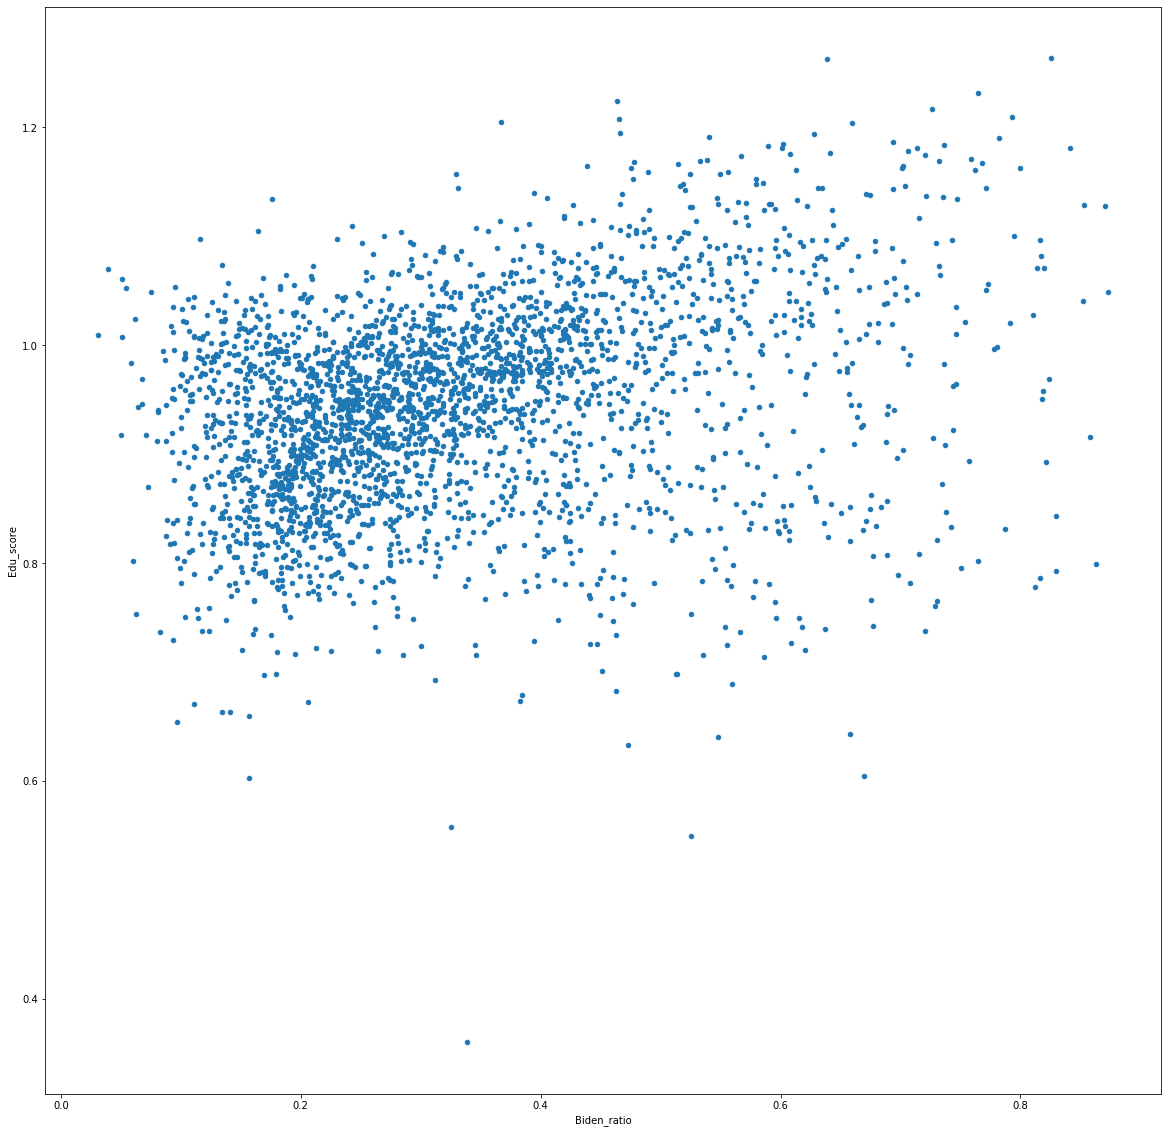

In [14]:
plt.rcParams['figure.figsize'] = [20, 20]
# Here we will pick Biden_ratio as the X series and Edu_score for Y. Keeping those choices in variables because be might
# change our mind later

df_x = 'Biden_ratio'
df_y = 'Edu_score'

df_edu.plot.scatter(x=df_x, y=df_y)
plt.show()

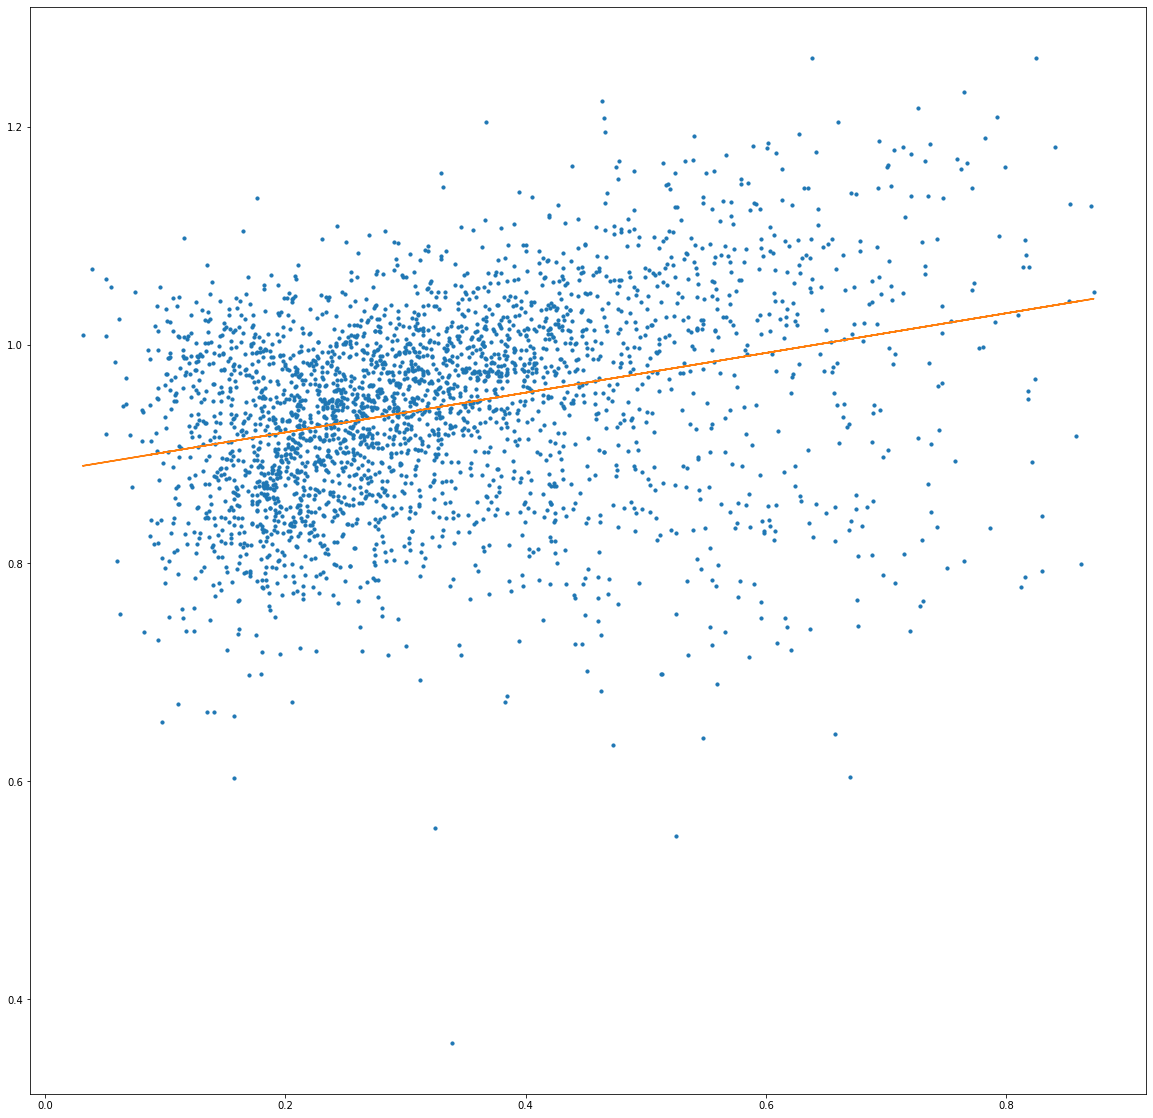

In [15]:
# and now to calculate a linear regression:
def lin_regr(x, y, df):
    xy = df[x] * df[y]
    xx = df[x] * df[x]

    n = len(df)

    sigma_x = df[x].sum()
    sigma_y = df[y].sum()
    sigma_xy = xy.sum()
    sigma_xx = xx.sum()

    m = (n*sigma_xy-sigma_x*sigma_y)/(n*sigma_xx-sigma_x*sigma_x)
    b = (sigma_y-m*sigma_x)/n
    # now to create our vector arrays and plotting the linear regression

    # df_edu['lr_x'] = range(len(df_edu))
    y_series = m*df[x]+b
    return y_series

lr_y = lin_regr(df_x, df_y, df_edu)

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(df_edu[df_x], df_edu[df_y], s=10)
ax.plot(df_edu[df_x], lr_y, color='C1')
plt.show()

In [16]:
# df_edu.sort_values(by=['Edu_score'])

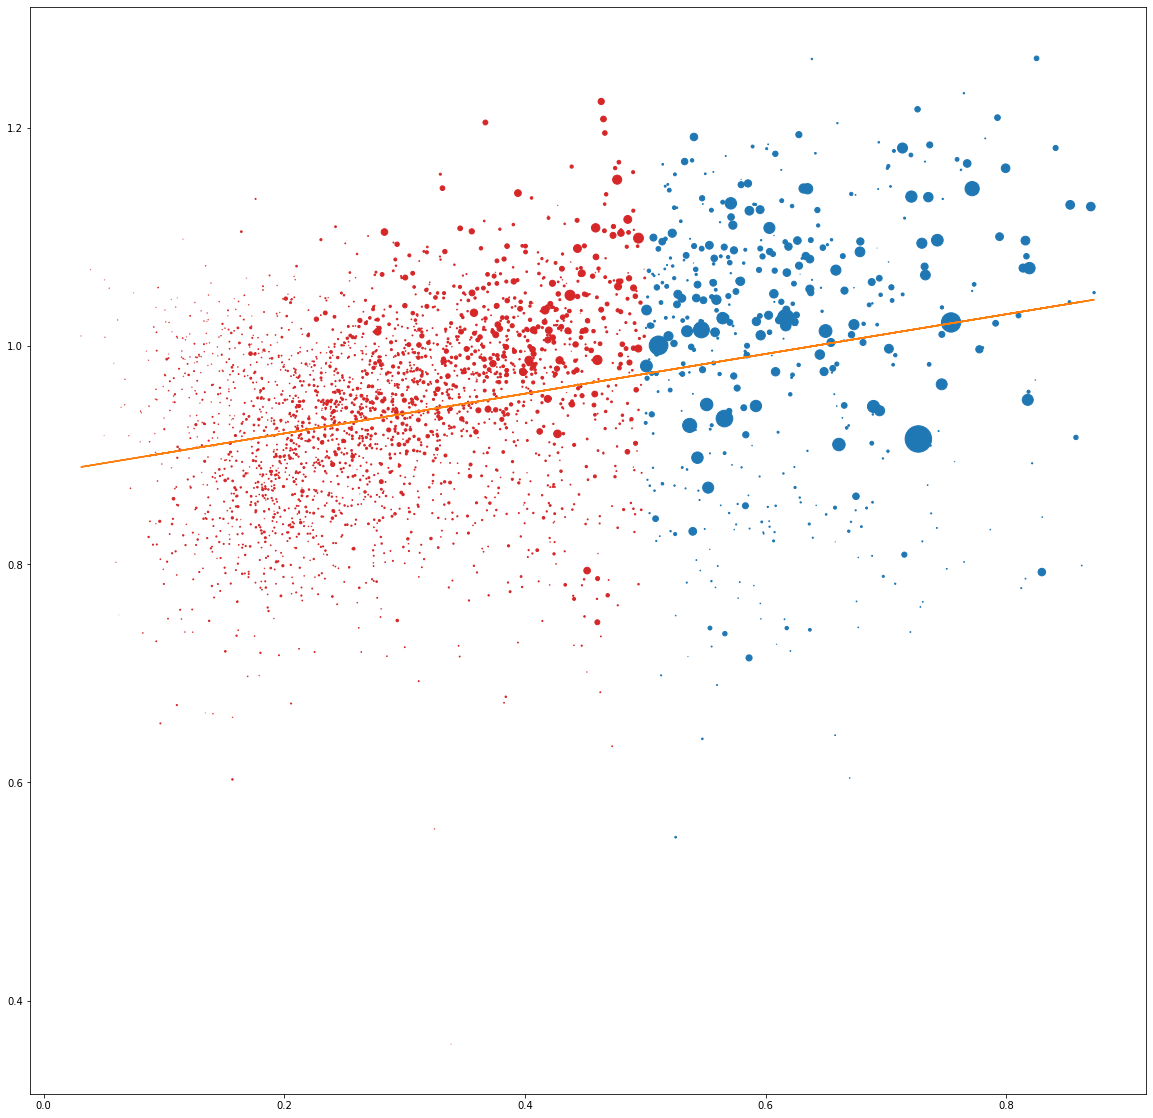

In [17]:
k = 10/df_edu['total votes'].max()
df_edu['total_votes_plot'] = df_edu['total votes']*k*70
df_edu['total_votes_plot'] = df_edu['total_votes_plot']

fig, ax = plt.subplots(figsize=(20, 20))
sc = ax.scatter(df_edu[df_x], df_edu[df_y], s=df_edu['total_votes_plot'], c=df_edu['Winner'])

ax.plot(df_edu[df_x], lr_y, color='C1')
plt.show()

<IPython.core.display.Javascript object>


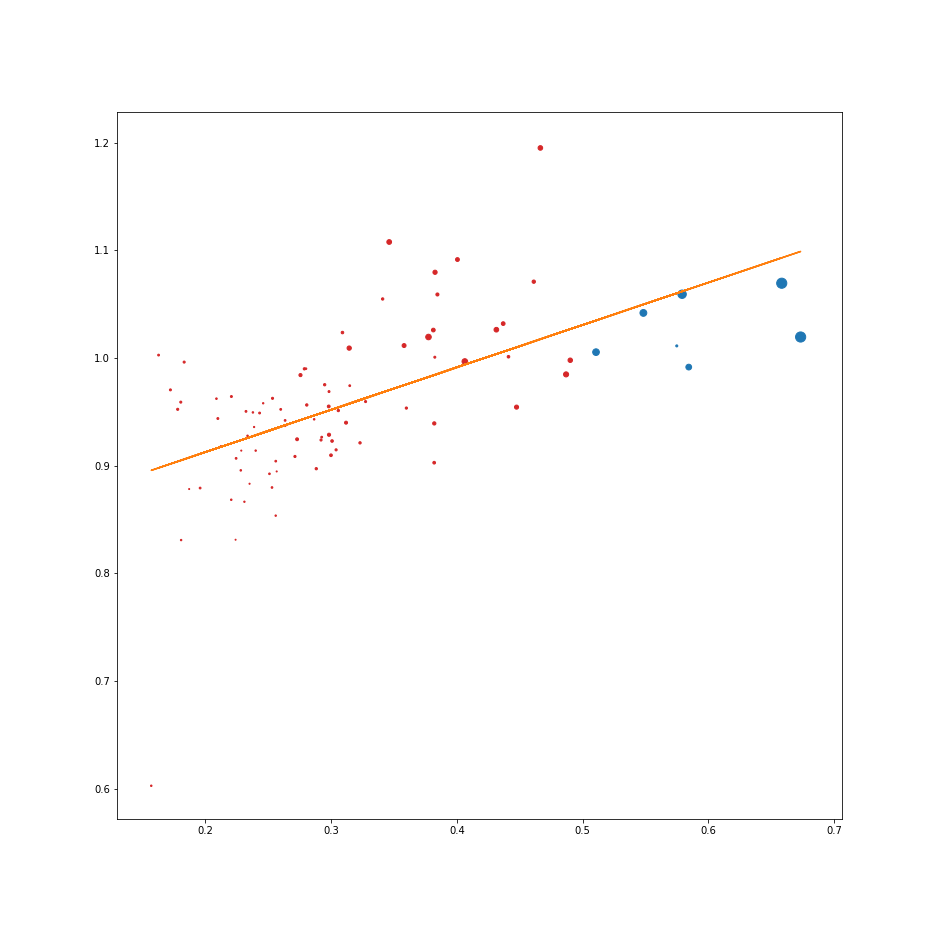

In [31]:
%matplotlib notebook
%matplotlib notebook

# Use df2 to filter the dataset.
# E.g.: 
df2 = df_edu[df_edu.state=='OH']
# df2 = df_edu[df_edu['Trump_ratio'] < df_edu['Biden_ratio']]
# df2 = df_edu[df_edu['Edu_score'] > 1]

# df2 = df_edu[df_edu['Edu_score'] > 1]

fig,ax = plt.subplots(figsize=(13, 13))
sc = plt.scatter(df2[df_x],df2[df_y], s=df2['total_votes_plot'], c=df2['Winner'])

annot = ax.annotate("", xy=(0,0), xytext=(-100,15),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"), arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = ' | '.join(df2.concat[n] for n in ind["ind"])
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)


lr_y = lin_regr(df_x, df_y, df2)
ax.plot(df2[df_x], lr_y, color='C1')

plt.show()

In [28]:
df_edu.state.unique()

array(['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID',
       'IL', 'IN', 'IA', 'KS', 'KY', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
       'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
       'WA', 'WV', 'WI', 'WY'], dtype=object)